### 新データ等を使ってネットワークの書き方等をテストするファイル

In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
from dgl.nn import GraphConv,MaxPooling
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import time
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os
import yaml

from torchviz import make_dot
from IPython.display import display
%matplotlib inline

In [2]:
class STL10TrainDataset(DGLDataset):
    def __init__(self,data_path,transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        super().__init__(name='stl10_train_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入
        self.dim_nfeats=len(self.graphs[0].ndata['feat'][0])

    def __getitem__(self, idx):
        if self.transforms == None:
            return self.graphs[idx], self.labels[idx]
        else:
            data=self.transforms(self.graphs[idx])
            return data,self.labels[idx]
    def __len__(self):
        return len(self.graphs)


class STL10TestDataset(DGLDataset):
    def __init__(self,data_path,transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        super().__init__(name='stl10_test_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入
        self.dim_nfeats=len(self.graphs[0].ndata['feat'][0])

    def __getitem__(self, idx):
        if self.transforms == None:
            return self.graphs[idx], self.labels[idx]
        else:
            data=self.transforms(self.graphs[idx])
            return data,self.labels[idx]
        
    def __len__(self):
        return len(self.graphs)

In [3]:
#transform = transforms.Compose([transforms.Normalize(0,1)])
traindataset=STL10TrainDataset('../data/STL10 Datasets/train/nnum20_ndatapic9_enone_akaze.dgl')
testdataset=STL10TestDataset('../data/STL10 Datasets/test/nnum20_ndatapic9_enone_akaze.dgl')

In [4]:
if os.name =='posix':
    num_workers = 2
else:
    num_workers = 0
num_workers = 0
traindataloader = GraphDataLoader(traindataset,batch_size = 50,shuffle = True,num_workers = num_workers,pin_memory = True)
testdataloader = GraphDataLoader(testdataset,batch_size = 1000,shuffle = True,num_workers = num_workers,pin_memory = True)
print(f'num_wokers = {num_workers}')
print(os.name)

num_wokers = 0
posix


In [33]:
print(traindataset[0][0].ndata['feat'].shape)
print(traindataset.dim_nfeats)
print(traindataset[0][0].ndata['feat'][0])
print(testdataset[0][0])

torch.Size([20, 9, 9])
9
tensor([[0.3918, 0.4027, 0.4130, 0.4230, 0.4337, 0.4461, 0.4604, 0.4755, 0.4891],
        [0.3889, 0.3991, 0.4103, 0.4225, 0.4356, 0.4496, 0.4639, 0.4774, 0.4878],
        [0.3873, 0.3962, 0.4074, 0.4204, 0.4347, 0.4496, 0.4641, 0.4768, 0.4856],
        [0.3881, 0.3950, 0.4048, 0.4170, 0.4308, 0.4457, 0.4602, 0.4732, 0.4825],
        [0.3918, 0.3962, 0.4031, 0.4125, 0.4243, 0.4379, 0.4525, 0.4668, 0.4786],
        [0.3986, 0.4000, 0.4029, 0.4080, 0.4160, 0.4274, 0.4417, 0.4580, 0.4737],
        [0.4084, 0.4066, 0.4047, 0.4043, 0.4074, 0.4156, 0.4291, 0.4475, 0.4676],
        [0.4211, 0.4163, 0.4093, 0.4028, 0.4001, 0.4041, 0.4162, 0.4360, 0.4602],
        [0.4363, 0.4288, 0.4168, 0.4042, 0.3954, 0.3947, 0.4044, 0.4247, 0.4517]])
Graph(num_nodes=20, num_edges=380,
      ndata_schemes={'feat': Scheme(shape=(9, 9), dtype=torch.float32)}
      edata_schemes={})


In [12]:
for g,l in traindataloader:
    print(g.ndata['feat'][0].shape)
    break

torch.Size([9, 9])


In [13]:
data=g.ndata['feat'][0]
print(data)
flat=data.reshape(81)
print(flat)

tensor([[0.5372, 0.5377, 0.5382, 0.5390, 0.5401, 0.5418, 0.5442, 0.5470, 0.5499],
        [0.5392, 0.5393, 0.5394, 0.5396, 0.5404, 0.5417, 0.5437, 0.5462, 0.5489],
        [0.5411, 0.5409, 0.5407, 0.5406, 0.5410, 0.5420, 0.5436, 0.5457, 0.5481],
        [0.5427, 0.5423, 0.5419, 0.5417, 0.5418, 0.5426, 0.5438, 0.5455, 0.5474],
        [0.5437, 0.5433, 0.5429, 0.5427, 0.5428, 0.5434, 0.5443, 0.5455, 0.5468],
        [0.5443, 0.5441, 0.5439, 0.5438, 0.5440, 0.5444, 0.5450, 0.5457, 0.5465],
        [0.5448, 0.5447, 0.5448, 0.5450, 0.5454, 0.5457, 0.5461, 0.5464, 0.5466],
        [0.5453, 0.5455, 0.5459, 0.5465, 0.5470, 0.5474, 0.5475, 0.5475, 0.5473],
        [0.5460, 0.5465, 0.5473, 0.5481, 0.5488, 0.5493, 0.5493, 0.5490, 0.5485]])
tensor([0.5372, 0.5377, 0.5382, 0.5390, 0.5401, 0.5418, 0.5442, 0.5470, 0.5499,
        0.5392, 0.5393, 0.5394, 0.5396, 0.5404, 0.5417, 0.5437, 0.5462, 0.5489,
        0.5411, 0.5409, 0.5407, 0.5406, 0.5410, 0.5420, 0.5436, 0.5457, 0.5481,
        0.5427, 0.542

In [9]:
#従来の静的ネットワーク構築
class GCN(nn.Module):
    def __init__(self):
        super(GCN,self).__init__()
        self.conv1=GraphConv(81,40,weight=True)
        self.conv2=GraphConv(40,10,weight=True)
        self.flatt=nn.Flatten()

    
    def forward(self,g,n_feat,e_feat=None):
        n_feat=self.flatt(n_feat)
        h=self.conv1(g,n_feat,None,e_feat)
        h=self.conv2(g,h,None,e_feat)
        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')
    

#新規の動的ネットワーク構築。設定はconfig.yamlに書かれている。テストコードはtest.ipynb
class DynamicGCN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(DynamicGCN,self).__init__()
        self.input_layer=GraphConv(input_size,hidden_size[0])
        self.middle_layers=nn.ModuleList([GraphConv(hidden_size[i],hidden_size[i+1]) for i in range(len(hidden_size)-1)])
        self.output_layer=GraphConv(hidden_size[-1],output_size)

        self.flatt=nn.Flatten()

    
    def forward(self,g,n_feat,e_feat=None):
        n_feat=self.flatt(n_feat)
        h=self.input_layer(g,n_feat,None,e_feat).clamp(0)
        for layer in self.middle_layers:
            h=layer(g,h).clamp(0)
        h=self.output_layer(g,h).clamp(0)
        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')


In [48]:
model = GCN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.008)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 200

In [30]:
save_train_acc = []
save_test_acc = []

In [49]:
loss_list = []
acc_list = []
test_acc_list = []


num_correct = 0
num_tests = 0
test_num_correct = 0
test_num_tests = 0
lossF = nn.CrossEntropyLoss()
#,batched_graph.edata['distance'].float()
BP = 0
for epoch in tqdm(range(epochs)):
    if BP != 0:
        break
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat'])
        loss = lossF(pred,labels)
        if loss.item() < 0.05:
            BP = 0
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    loss_list.append(loss.item())
    acc_list.append(num_correct / num_tests) #学習中トレーニングacc
    
    model.eval()
    for tbatched_graph, tlabels in testdataloader:
        tbatched_graph = tbatched_graph.to(device)
        tlabels = tlabels.to(device)
        tpred = model(tbatched_graph, tbatched_graph.ndata['feat'])
        test_num_correct += (tpred.argmax(1) == tlabels).sum().item()
        test_num_tests += len(tlabels)

    Tacc = test_num_correct / test_num_tests
    #print('Training accuracy:', Tacc)
    test_acc_list.append(Tacc) #学習中テストacc


100%|██████████| 200/200 [00:04<00:00, 40.04it/s]


In [50]:
num_correct = 0
num_tests = 0



with torch.no_grad():
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat'])
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Training accuracy:', num_correct / num_tests)
    save_train_acc.append(num_correct / num_tests)
    num_correct = 0
    num_tests = 0
    model.eval()
    for batched_graph, labels in testdataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat'])
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Test accuracy:', num_correct / num_tests)
    save_test_acc.append(num_correct / num_tests)

Training accuracy: 0.1782178217821782
Test accuracy: 0.0891089108910891


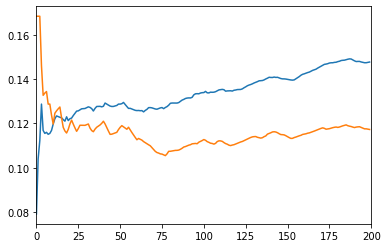

In [51]:
x=[i for i in range(len(acc_list))]
y_train=acc_list
y_test=test_acc_list
plt.xlim(0,epochs)
plt.plot(x,y_train)
plt.plot(x,y_test)

plt.show()

以下動的ネットワークによる学習  
設定ファイル：config.yaml  
ネットワーク名：DynamicGCN

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#設定ファイル読み込み
with open('config.yaml','r') as f:
    config=yaml.safe_load(f)

#パラメータ設定
lr=0.001
epochs=100

#モデルの学習
for model_name, model_config in config.items():
    #結果を保存するディレクトリを作成
    save_dir=f'save/{model_name}'
    os.makedirs(save_dir,exist_ok=True)


    #モデルの初期化
    model=DynamicGCN(model_config['input_size'],model_config['hidden_size'],model_config['output_size'])
    model.to(device)
    lossF=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=lr)

    #情報保存用の変数の初期化
    #トレーニング用
    num_correct=0
    num_tests=0
    train_loss_list = []
    train_acc_list = []
    #テスト用
    test_num_correct = 0
    test_num_tests = 0
    test_acc_list = []

    for epoch in tqdm(range(epochs)):
        #トレーニング
        model.train()
        for batched_grapg, labels in traindataloader:
            batched_grapg = batched_grapg.to(device)
            labels = labels.to(device)
            pred = model(batched_grapg,batched_grapg.ndata['feat'])
            loss=lossF(pred,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)
        train_loss_list.append(loss.item())
        train_acc_list.append(num_correct / num_tests)
        #カウントリセット
        num_correct=num_tests=0

        #テスト
        model.eval()
        for tbatched_graph, tlabels in testdataloader:
            tbatched_graph = tbatched_graph.to(device)
            tlabels = tlabels.to(device)
            tpred = model(tbatched_graph, tbatched_graph.ndata['feat'])
            test_num_correct += (tpred.argmax(1) == tlabels).sum().item()
            test_num_tests += len(tlabels)

        test_acc_list.append(test_num_correct/test_num_tests)
        #カウントリセット
        test_num_correct=test_num_tests=0

    #完全学習後の正答率の計算(推論)
    with torch.no_grad():
        #情報保存用の変数の初期化
        #トレーニング用
        num_correct=0
        num_tests=0
        save_train_acc=0
        #テスト用
        test_num_correct = 0
        test_num_tests = 0
        save_test_acc=0

        #全トレーニングデータでの正答率計算
        model.train()
        for batched_graph, labels in traindataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = model(batched_graph, batched_graph.ndata['feat'])
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)
        print('Training accuracy:', num_correct / num_tests)
        save_train_acc=(num_correct / num_tests)

        #全テストデータでの正答率
        model.eval()
        for batched_graph, labels in testdataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = model(batched_graph, batched_graph.ndata['feat'])
            test_num_correct += (pred.argmax(1) == labels).sum().item()
            test_num_tests += len(labels)
        print('Test accuracy:', test_num_correct / test_num_tests)
        save_test_acc=(test_num_correct / test_num_tests)

    #各エポックごとの損失・正答率の記録をモデルごとに.npy形式で保存
    np.save(f'{save_dir}/train_loss_list',train_loss_list)
    np.save(f'{save_dir}/train_acc_list',train_acc_list)
    np.save(f'{save_dir}/test_acc_list',test_acc_list)
    #完全学習後のトレーニング・テストデータそれぞれの正答率を.yaml形式で保存
    log={'train acc':save_train_acc,
         'test acc':save_test_acc}
    with open(f'{save_dir}/acc_result.yaml',"w") as f:
        yaml.dump(log,f)

100%|██████████| 100/100 [00:03<00:00, 31.79it/s]


Training accuracy: 0.13861386138613863
Test accuracy: 0.12871287128712872


100%|██████████| 100/100 [00:03<00:00, 32.34it/s]

Training accuracy: 0.1188118811881188
Test accuracy: 0.13861386138613863


: 

In [15]:
save_dir=f'save/{model_name}'
os.makedirs(save_dir,exist_ok=True)